### General approach

Our goal is to construct a low-rank approximation of a data matrix $A$ of DNA methylation patterns (with many missing data points). Each row of $A$ contains a binary sequence of methylation, $A_{ij} = 1$ for methylated sites, $A_{ij} = 0$ for unmethylated sites, and $A_{ij} = \text{NA}$ when site $j$ is unobserved in read $i$. We factor $A$ as a product of two matrices $X$ and $Y$:

$$
A = XY \\ A \in \mathbf{R}^{m \times n},~~ X \in \mathbf{R}^{m \times k},~~ Y \in \mathbf{R}^{k \times n}
$$

That is, we have a dataset $m$ reads that provide partial information over $n$ methylation-eligible sites of interest (e.g. over a selected number of genes, or, more ambitiously, over the entire genome). We suppose that there are no more than $k$ types of cells with distinct methylation patterns.

The rows of $Y$ provide the estimates for the $k$ distinct methylation patterns. A row of $X$ assigns the relative probabilities for that read to one of the $k$ patterns. An interesting question is whether we believe the rows of $X$ to be sparse. A sparse rowspace of $X$ would correspond to there being distinct methylation patterns across cell types, with little to no mixed patterns. A non-sparse rowspace would allow for a spectrum of different DNA methylation profiles.

### Niave Optimization Approach

We use $x_i$ to denote row $i$ of $X$, and $y_j$ to denote column $j$ of $Y$, so that $x_i y_j$ is a vector dot product. Let $(i,j) \in \Omega$ denote the indices of observed entries in $A$. Then a low-rank approximation can be achieved by solving the unconstrained optimization problem:

$$
\begin{aligned}
& \underset{X,Y}{\text{minimize}}
& & \sum_{(i,j) \in \Omega} \log(1+\exp(-A_{ij} (x_i y_j)) - \gamma ||X||_F^2 - \gamma||Y||_F^2 
\end{aligned}
$$

The first term is a logistic loss function. The last two are regularization terms that penalize the *Frobenius norm* of the matrices. [Udell et al. (2014)](http://web.stanford.edu/~udell/doc/glrm.pdf) show that this problem is equivalent to the rank-constrained nuclear-norm regularized problem:

$$
\begin{aligned}
& \underset{X,Y}{\text{minimize}}
& & \sum_{(i,j) \in \Omega} \log(1+\exp(-A_{ij} (x_i y_j)) - 2 \gamma ||XY||_*^2 \\
& \text{subject to}
& & \text{rank}(Z) \leq k
\end{aligned}
$$

as long as $k$ is chosen to be larger than the true rank of $A$. The *Frobenius norm* and *nuclear norm* are respectively defined as:

$$
||X||_F = \sqrt{\sum_{i=1}^k \sigma_i^2} = \sqrt{ \text{trace} \left ( X^T X \right ) } \\
||X||_* = \sum_{i=1}^k \sigma_i = \text{trace} \left ( \sqrt{X^T X} \right )
$$

### Ideas for improvement

Clustering variation: have the rows of $X$ be one-sparse

Combination/spectrum of cell types variation: have the rows of $X$ sum to one and have non-negative elements

### Relevant Papers on Matrix Completion

Emmanuel J. Candès, Benjamin Recht. [Exact Matrix Completion via Convex Optimization](http://dx.doi.org/10.1007/s10208-009-9045-5). *Found Comput Math* 9, 717–772 (2009)

Emmanuel J. Candès, Terence Tao. [The Power of Convex Relaxation: Near-Optimal Matrix Completion](http://dx.doi.org/10.1109/tit.2010.2044061). *IEEE Transactions on Information Theory* 56, 2053–2080 (2010).

Emmanuel J Candès, Yaniv Plan. [Matrix Completion With Noise](http://dx.doi.org/10.1109/jproc.2009.2035722). *Proc. IEEE* 98, 925–936 (2010).

Benjamin Recht, Maryam Fazel, Pablo A. Parrilo. [Guaranteed Minimum-Rank Solutions of Linear Matrix Equations via Nuclear Norm Minimization](http://dx.doi.org/10.1137/070697835). *SIAM Rev.* 52, 471–501 (2010).

In [1]:
using LowRankModels
using Distributions
include("methylation_functions.jl");

INFO: Loading help data...


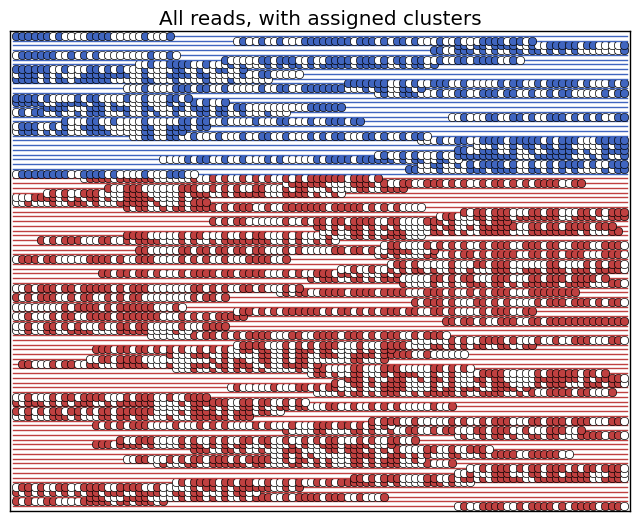

PyObject <matplotlib.text.Text object at 0x7f4822a553d0>

In [25]:
A,P,c = generate_reads(N=100,W=49)
plot_meth(A,c)

In [3]:
# find indices of observed find(~isnan(X[:,1])
m,n = size(A)
k = 2 # we know there are two cell types

obs = (Int64,Int64)[]
for i = 1:m
    for j = 1:n
        if ~isnan(A[i,j])
            push!(obs,(i,j))
        end
    end
end

In [4]:
losses = fill(logistic(),n)
rx = unitonesparse()
ry = zeroreg()
glrm = GLRM(A,obs,losses,rx,ry,k)
X,Y,ch = fit!(glrm)
println("Convergence history:",ch.objective)

Fitting GLRM
obj went up to 74653.23412210034; reducing step size to 0.7000000000000001
obj went up to 73282.7670176727; reducing step size to 0.46666666666666673
obj went up to 72447.33479167824; reducing step size to 0.31111111111111117
obj went up to 71925.57002092266; reducing step size to 0.15555555555555559
obj went up to 71432.19114944631; reducing step size to 0.051851851851851864
obj went up to 71119.13471645706; reducing step size to 0.012962962962962966
obj went up to 71005.02337068504; reducing step size to 0.0025925925925925934
Convergence history:[Inf,70967.38521509351,70967.38521509351]


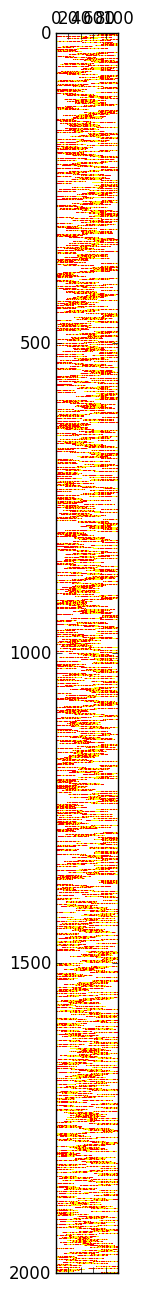

PyObject <matplotlib.image.AxesImage object at 0x7f48522cd850>

In [5]:
matshow(A,cmap=ColorMap("autumn"))

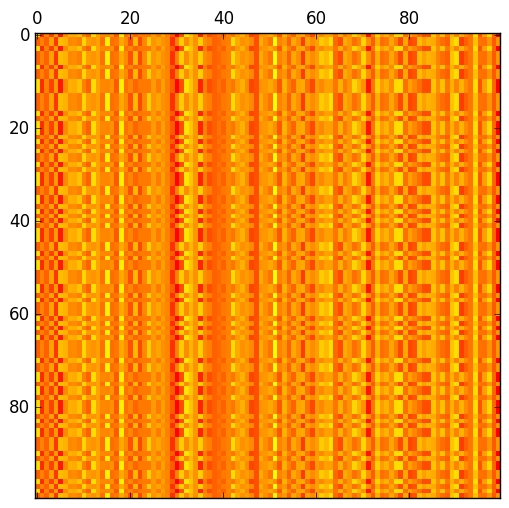

PyObject <matplotlib.image.AxesImage object at 0x7fbf5dfcc710>

In [6]:
matshow(X*Y,cmap=ColorMap("autumn"))

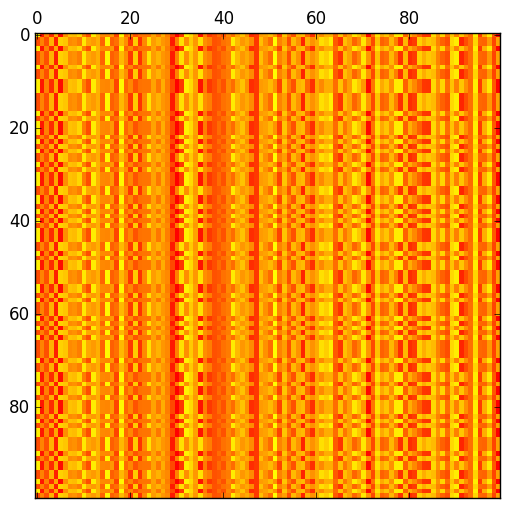

PyObject <matplotlib.image.AxesImage object at 0x7fbf5de67dd0>

In [7]:
B = 2./(1+exp(-X*Y)) - 1
matshow(B,cmap="autumn")

In [21]:
minimum(log(P./(1-P)))

-9.332127806436615

In [24]:
maximum(Y)

2.3399799534838905

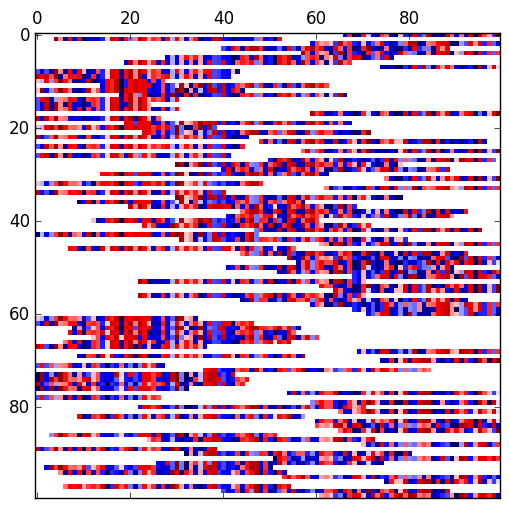

PyObject <matplotlib.image.AxesImage object at 0x7fbf5e12ce10>

In [8]:
matshow(A-B,cmap="seismic")

In [13]:
P

2x100 Array{Float64,2}:
 0.479439  0.413796  0.572165  0.190855  …  0.97805   0.0748281  0.530803
 0.112176  0.632324  0.056685  0.705191     0.317205  0.69404    0.484586